# Notes:-
* We looked at the C4.5 Algorithm and tried to get it working with all the ensemble methods, but it turned out to be too much of pain and not worth the effort.
* This code uses CART instead of c4.5. They both are pretty close to each other. Refer documentation for difference.
* This code uses SAMME.R for Adaboost instead of ADaboost.MI used for boosting in the paper.

# Links to documentations
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.Bagging
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
* http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.fit

# CLEANING
* We are using datasets from the UCI repository.
* Lots of cleaning needed. Convert everything to a constant format to parse. Tab separate, comma separated, colon separated, etc
* Add missing headers
* Prep missing values using imputing.
* Categorical data needs to be mapped to dummy numerical values for trees to work properly.
* Some of classes in the datasets had too few elements, python complained about it during cross_validation_tests

In [17]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

# Import stuff
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.preprocessing import Imputer

In [9]:
CSV_SEP = ','

# get list of datasets of UCI rep to use
def get_dataset_list():
    datasets = [
                'data/winequality-red.csv',
                'data/winequality-white.csv',
                'data/house-votes-84.data.txt',
                'data/krkopt.data.txt',
                'data/letter-recognition.data.txt',
                'data/sat.trn.txt',
                'data/segment.dat.txt',
                'data/sonar.all-data.txt',
                'data/soybean-large.data.txt',
                'data/anneal.data.txt',

                # 'splice.data.txt' - Need to enter comma after every char ,rest cleaning is done.
                #'data/glass.data.txt', - This is continuous
                #'data/heart.dat.txt',- This is continuous
                ]

    return datasets

In [10]:
# Do bagging.
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_bagging(X, y):
    bagging = BaggingClassifier(DecisionTreeClassifier(), 200, 0.67, 1.0, True, True)
    return cross_val_score(bagging, X, y, cv=10)

# Do boosting
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_boosting(X, y):
    boosting = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100)
    return cross_val_score(boosting, X, y, cv=10)

# Do Randomization
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_randomization(X, y):
    random = ExtraTreesClassifier(200)
    return cross_val_score(random, X, y, cv=10)

# Do plain vanilla CART
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_cart(X, y):
    cart = DecisionTreeClassifier()
    return cross_val_score(cart, X, y, cv=10)

In [11]:
# Convert accuracy scores to error rates.
def convert_to_error_rate(score):
    error = []
    for foldscore in score:
        errorscore = 1 - foldscore
        error.append(errorscore)
    return error

# Remove missing values from data and replace then with NaN for imputer to work.
def remove_missing_values(arr):
    X = arr
    for row_ind, row in enumerate(arr):
        for col_ind, element in enumerate(row):
            if (element == '?'):
                X[row_ind][col_ind] = float('NaN') #Fixed number to identify missing values.
    return X

# Convert categorical feature data to dummy values to CART can work.
def convert_categorical_data(arr):
    X = []

    for row_ind, row in enumerate(arr):
        # create a map from your variable names to unique integers:
        intmap = dict([(val, i) for i, val in enumerate(set(row))])
        # make the new array hold corresponding integers instead of strings:
        new_vals = [intmap[val] for val in row]
        X.append(new_vals)
    return X

In [13]:
# Main
scores = []
error_rates = []
mean_error_rates = []
for dataset_url in get_dataset_list():
    print("Testing: "+dataset_url)
    datascore = []
    dataerrorrate = []

    # Read data.
    df = pd.read_csv(dataset_url, CSV_SEP)

    # Remove non attribute columns.
    Y = df['class'].values
    if ('instance' in df):
        df.drop('instance', 1)
    df = df.drop('class', 1)

    # Prep data.
    df.fillna(df.mode().iloc[0])
    X = df.as_matrix()
    X = remove_missing_values(X)
    X = convert_categorical_data(X)
    imp = Imputer(strategy='most_frequent', axis=0)
    imp.fit(X, Y)
    X = imp.transform(X)

    # Get cross validation scores.
    cart_score = do_cart(X, Y)
    bagging_score = do_bagging(X, Y)
    boosting_score = do_boosting(X, Y)
    random_score = do_randomization(X, Y)

    # Store scores.
    datascore.append(cart_score)
    datascore.append(bagging_score)
    datascore.append(boosting_score)
    datascore.append(random_score)
    scores.append(datascore)

    # Get error rates.
    cart_error = convert_to_error_rate(cart_score)
    bagging_error = convert_to_error_rate(bagging_score)
    boosting_error = convert_to_error_rate(boosting_score)
    random_error = convert_to_error_rate(random_score)

    # Store error rates.
    dataerrorrate.append(cart_error)
    dataerrorrate.append(bagging_error)
    dataerrorrate.append(boosting_error)
    dataerrorrate.append(random_error)
    error_rates.append(dataerrorrate)

    # Calculate mean error rates.
    mean_error_rates.append([np.mean(cart_error), np.mean(bagging_error), np.mean(boosting_error), np.mean(random_error)])

Testing: data/winequality-red.csv
Testing: data/winequality-white.csv

/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 5 members, which is too few. The m


Testing: data/house-votes-84.data.txt
Testing: data/krkopt.data.txt
Testing: data/letter-recognition.data.txt

/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The m


Testing: data/sat.trn.txt
Testing: data/segment.dat.txt
Testing: data/sonar.all-data.txt
Testing: data/soybean-large.data.txt

/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)



Testing: data/anneal.data.txt

/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 8 members, which is too few. The m

/home/ankit/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


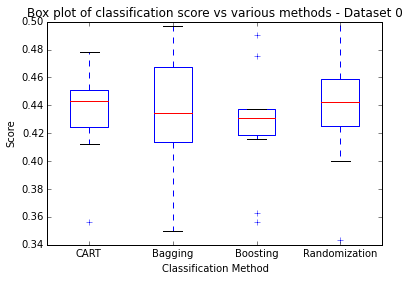

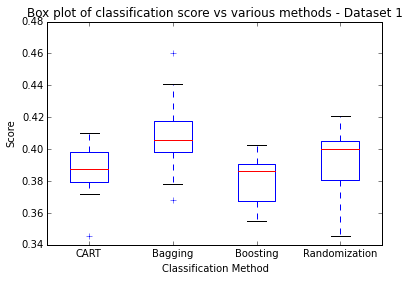

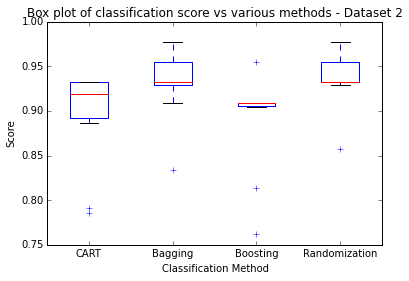

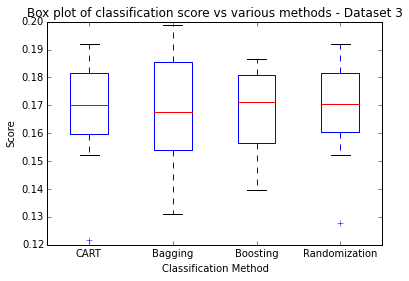

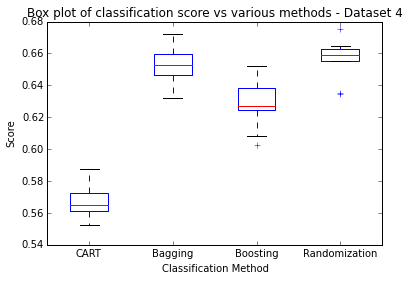

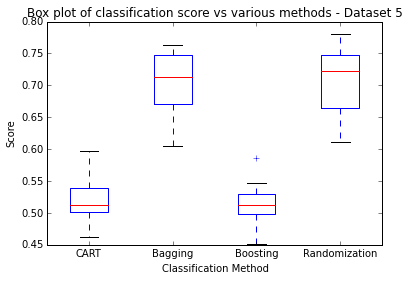

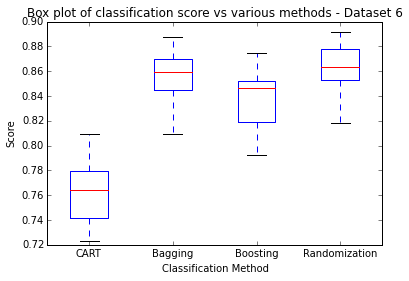

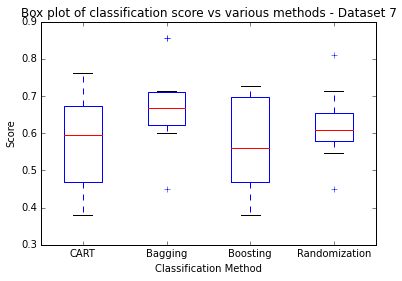

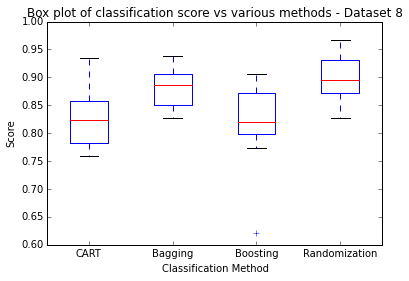

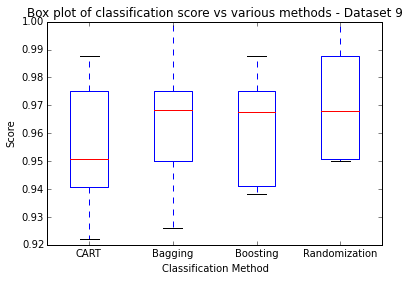

In [18]:
# Plot box plot - scores.
for idx, score in enumerate(scores):
    plt.boxplot(score, labels=['CART', 'Bagging', 'Boosting', 'Randomization'])
    plt.ylabel('Score')
    plt.xlabel('Classification Method')
    plt.title('Box plot of classification score vs various methods - Dataset ' + str(idx))
    plt.show()

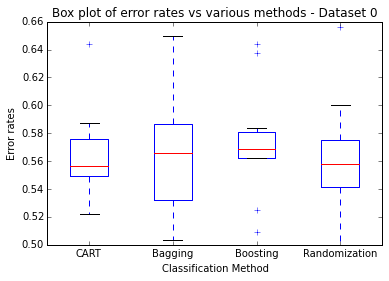

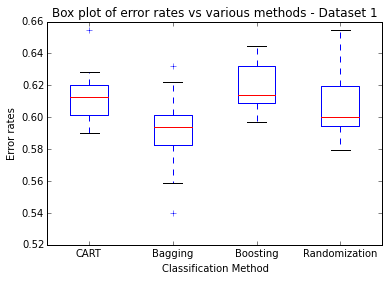

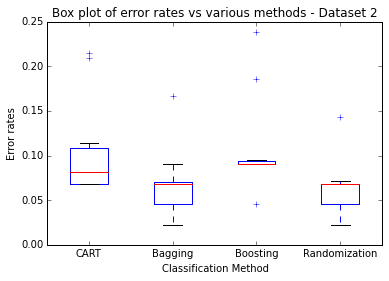

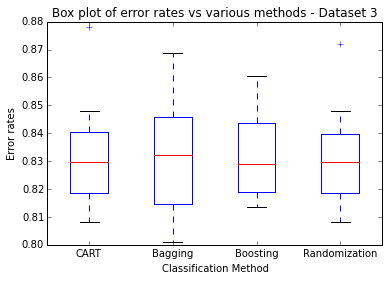

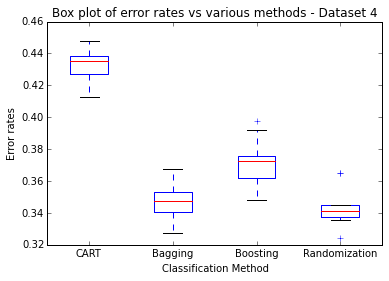

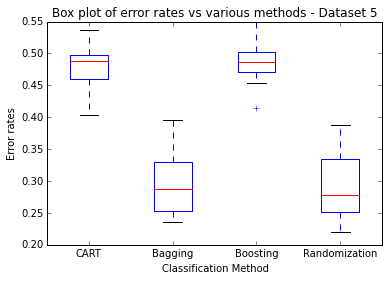

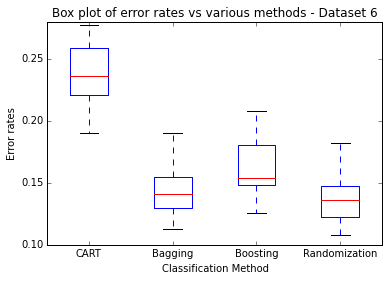

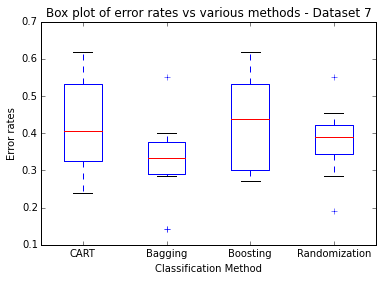

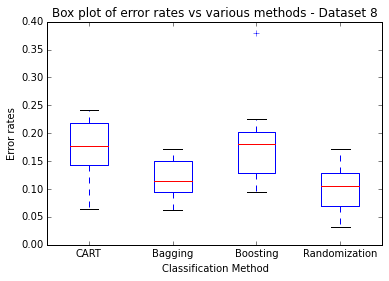

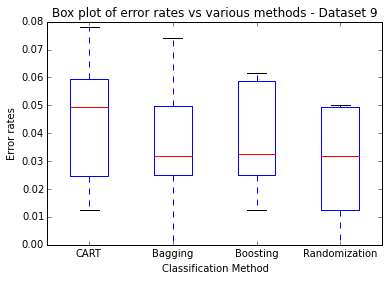

In [19]:
# Plot box plot - Error rates.
for idx, errorrate in enumerate(error_rates):
    plt.boxplot(errorrate, labels=['CART', 'Bagging', 'Boosting', 'Randomization'])
    plt.ylabel('Error rates')
    plt.xlabel('Classification Method')
    plt.title('Box plot of error rates vs various methods - Dataset ' + str(idx))
    plt.show()

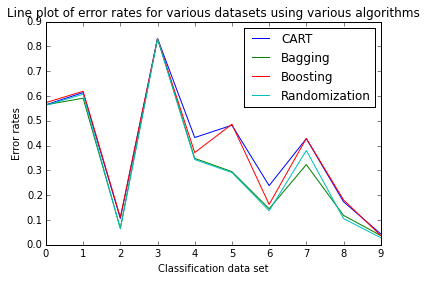

In [20]:
# Plot error rates of various algorithms
mean_error_rates = np.array(mean_error_rates)
plt.plot(mean_error_rates.T[0], label='CART')
plt.plot(mean_error_rates.T[1], label='Bagging')
plt.plot(mean_error_rates.T[2], label='Boosting')
plt.plot(mean_error_rates.T[3], label='Randomization')
plt.legend(loc='best')
plt.ylabel('Error rates')
plt.xlabel('Classification data set')
plt.title('Line plot of error rates for various datasets using various algorithms')
plt.show()